# Pretraining a Born Classifier

We'd like to extract as much performance form Born as possible, without complicating the model (we've seen that ensembling is not particularly effective anyhow, see the `born_ensemble.ipynb` notebook).

Pretraining seems like a natural way to go about it!

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import seaborn as sns

import joblib

from bornrule import BornClassifier

from utils import get_dataframe_for_pretraining, encode_categorical

## Data preparation

In [2]:
datadir = "data"
df_in = pd.read_parquet(os.path.join(datadir, "pretrain.parquet"))

df_out = get_dataframe_for_pretraining(df_in, num_processes=5)

[+] Loading data from prepared.parquet.


In [3]:
df_out.sample(15)

,sentence_id,token,pos,dep,ner_tag
29539997,4,35,NUM,nummod,CARDINAL
6077355,4,severity,NOUN,pobj,NONE
22779345,9,are,AUX,ROOT,NONE
16357366,7,Carter,PROPN,compound,PERSON
19021861,3,developed,VERB,ROOT,NONE
13139407,0,",",PUNCT,punct,NONE
5321173,1,Catholic,PROPN,compound,ORG
30883200,11,",",PUNCT,punct,NONE
15520949,0,Tete,PROPN,nsubj,ORG
2864912,161,cost,VERB,ccomp,NONE


In [4]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824413 entries, 0 to 35824412
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentence_id  int64 
 1   token        object
 2   pos          object
 3   dep          object
 4   ner_tag      object
dtypes: int64(1), object(4)
memory usage: 1.3+ GB


In [5]:
df_out['ner_tag'].value_counts()

ner_tag
NONE           26635602
ORG             2460284
PERSON          1723805
DATE            1662194
GPE             1188244
CARDINAL         425493
NORP             370960
LOC              271220
WORK_OF_ART      215003
FAC              195547
QUANTITY         193367
EVENT            176207
ORDINAL          122088
PRODUCT           51924
TIME              30588
LAW               29359
MONEY             27780
PERCENT           23396
LANGUAGE          21352
Name: count, dtype: int64

## Data processing

We'll encode the categorical values more or less as in the CoNLL case, i.e., to ordinal ones instead of one-hot encoded ones.

In [6]:
cols_to_encode = set(df_out.columns) - {'sentence_id', 'token'}
encoded_df, encoder_mappings = encode_categorical(df_out, cols_to_encode)

In [7]:
encoded_df.sample(15)

,sentence_id,token,dep,ner_tag,pos
28207010,6,to,34,9,1
35516139,1,Brazil,35,4,11
6466381,0,Church,35,12,11
32625095,1,UMMC,14,9,11
16710428,4,led,15,9,16
18393471,7,immigrants,8,9,7
1144539,0,College,35,3,11
2878677,9,percussion,14,9,7
10733575,1,and,12,9,4
19255227,1,such,32,9,0


Now we proceed as we did in the CoNLL notebook.

In [8]:
X_train_valid, X_test = train_test_split(encoded_df, test_size=0.15)
X_train, X_valid = train_test_split(X_train_valid, test_size=0.3)

In [9]:
y_train = X_train.ner_tag.to_list()
X_train = X_train.drop('ner_tag', axis=1)

y_valid = X_valid.ner_tag.to_list()
X_valid = X_valid.drop('ner_tag', axis=1)

y_test = X_test.ner_tag.to_list()
X_test = X_test.drop('ner_tag', axis=1)

In [10]:
dict_vec = DictVectorizer()

X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_valid.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Training

In [11]:
born = BornClassifier()
# ~8s to train on ~36M tokens is quite impressive!
born.fit(X_train, y_train)

BornClassifier()

We need to save the model, the fitted `DictVectorizer` and the fitted encoder mappings: these three pieces work together!

In [12]:
os.makedirs("runs", exist_ok=True)

In [13]:
timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")

clf_path = os.path.join("runs", f"clf_born_{timestamp}")
joblib.dump(born, clf_path)
print(f"[+] Classifier saved to {clf_path}.")

vec_path = os.path.join("runs", f"vec_clf_born_{timestamp}")
joblib.dump(born, clf_path)
print(f"[+] Vectoriser saved to  {vec_path}")

enc_maps_path = os.path.join("runs", f"encmap_clf_born_{timestamp}")
with open(enc_maps_path, "w") as file:
    json.dump(encoder_mappings, file)
print(f"[+] Encoder mappings saved to {enc_maps_path}")

[+] Classifier saved to ['runs/clf_born_27082024-204345'].
[+] Vectoriser saved to ['runs/vec_clf_born_27082024-204345']
[+] Encoder mappings saved to runs/encmap_clf_born_27082024-204345


In [14]:
y_pred = born.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.47      0.31      0.37     63669
           1       0.92      0.39      0.55    249069
           2       0.37      0.53      0.44     26450
           3       0.31      0.19      0.24     29342
           4       0.75      0.49      0.59    177461
           5       0.52      0.89      0.66      3228
           6       0.01      0.27      0.02      4367
           7       0.11      0.48      0.18     40909
           8       0.02      0.63      0.04      4209
           9       0.98      0.46      0.63   3997824
          10       0.77      0.70      0.73     55571
          11       0.07      0.97      0.13     18131
          12       0.86      0.15      0.26    368222
          13       0.06      0.57      0.12      3474
          14       0.12      0.93      0.22    258446
          15       0.10      0.29      0.15      7725
          16       0.60      0.49      0.54     29104
          17       0.08    

A curious result.

Perhaps visualising the confusion matrix will tell us more!

In [15]:
labels = encoder_mappings['ner_tag']
cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)), normalize='true')

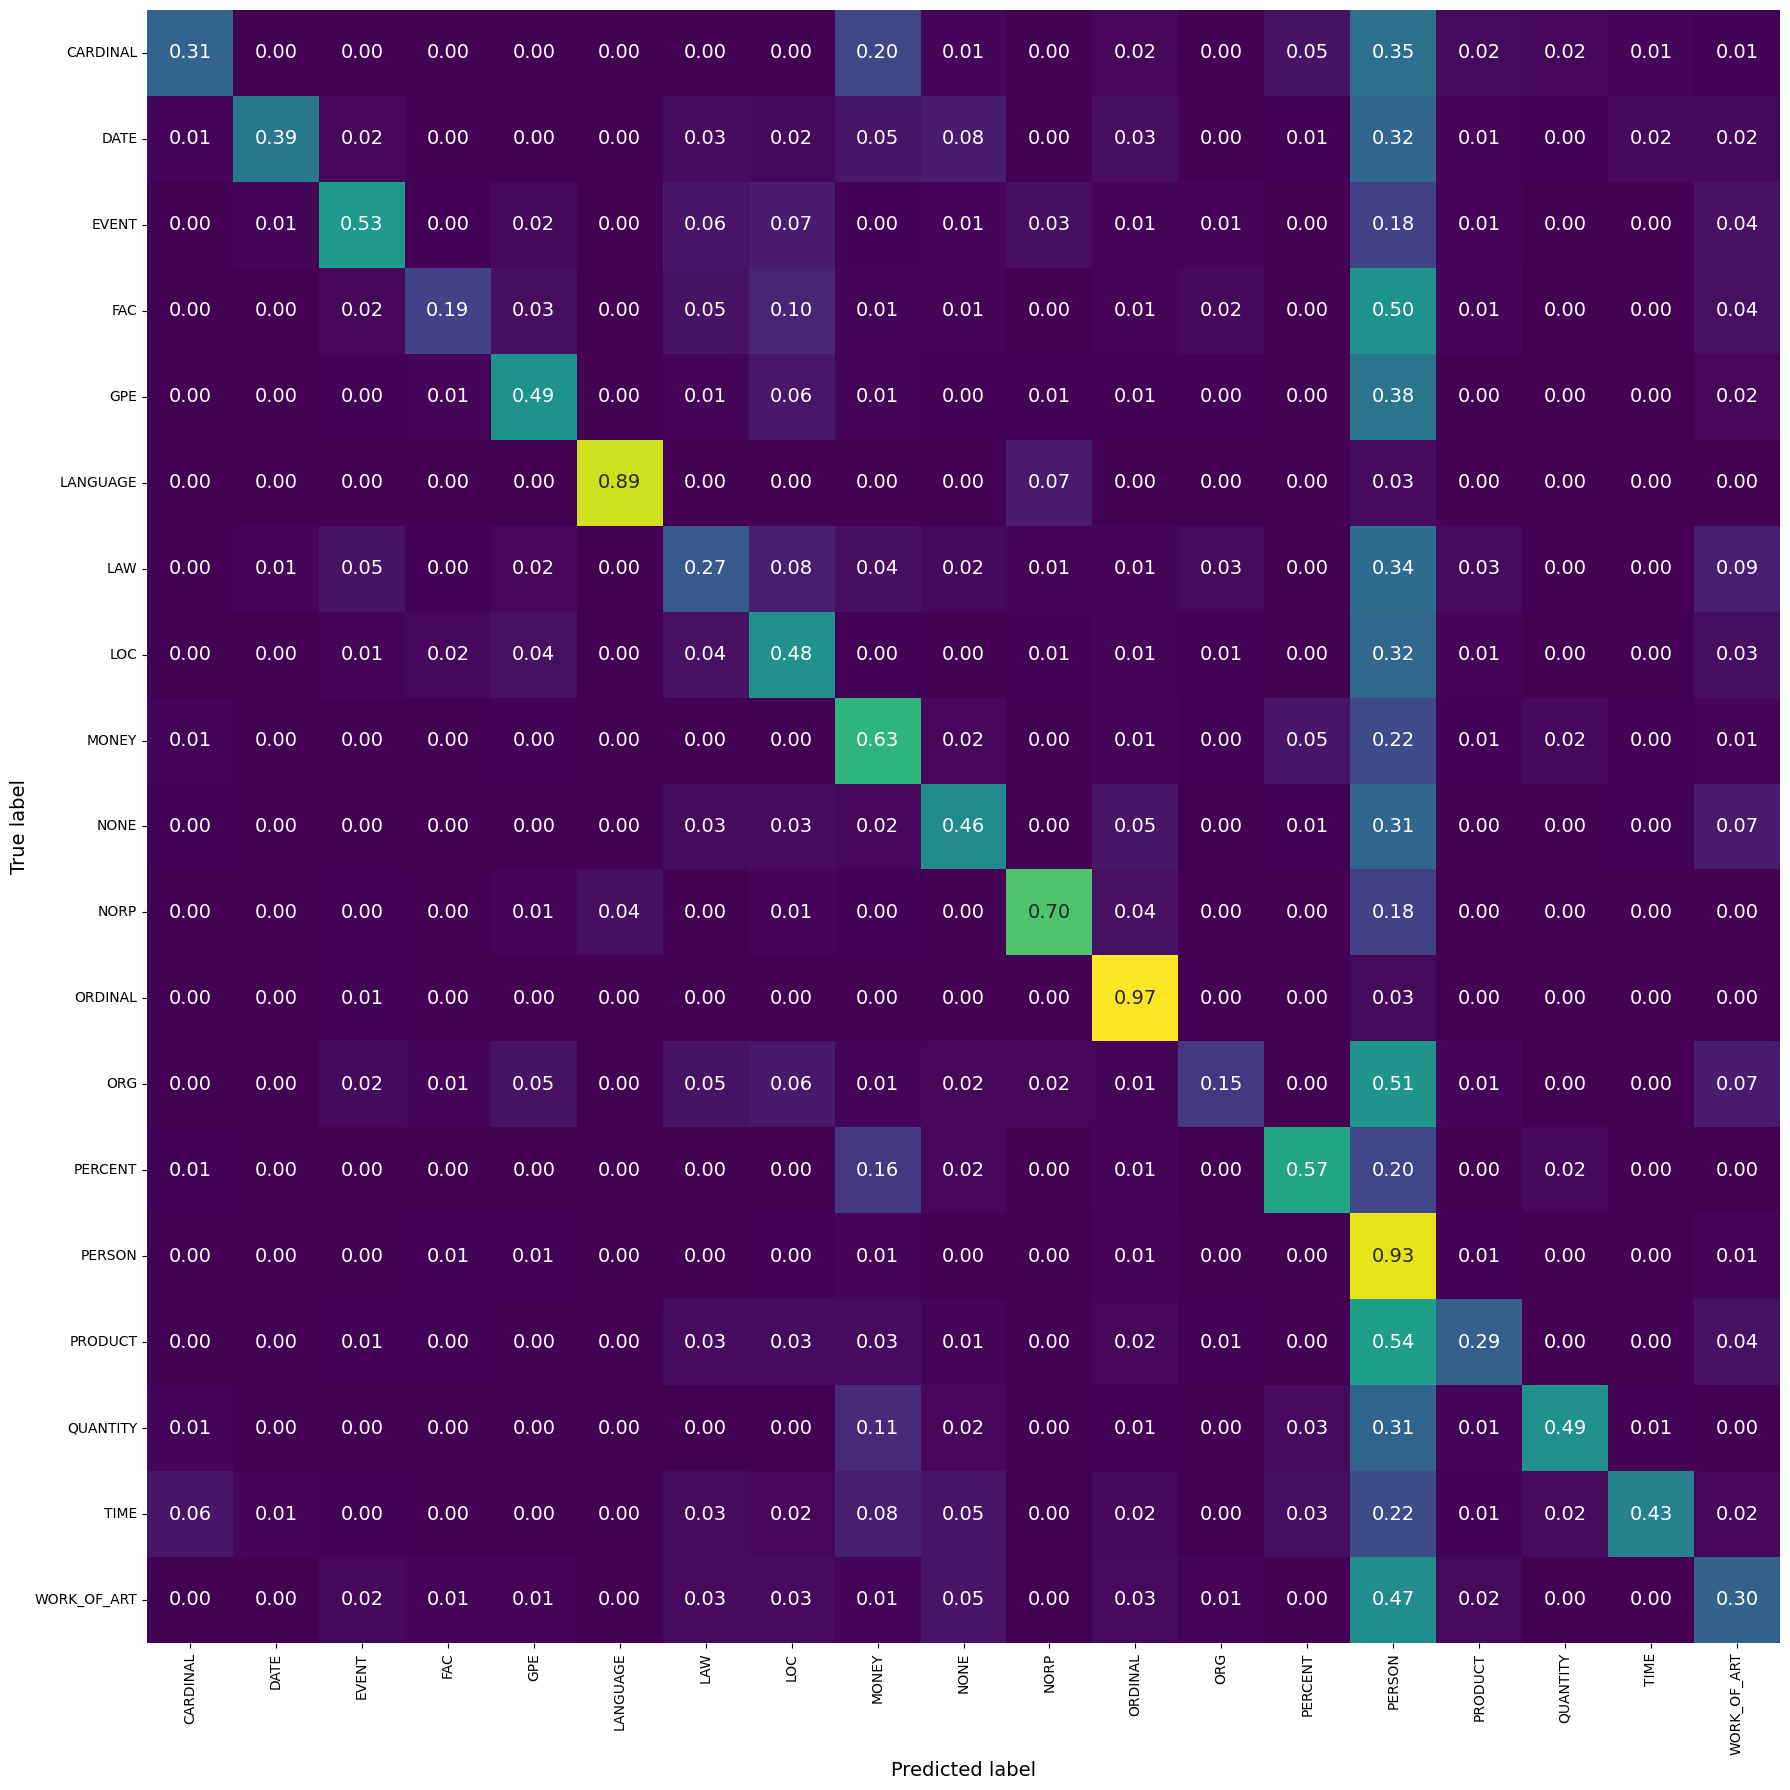

In [16]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(18, 18))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14}, cbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.tight_layout()
plt.show()

This confusion matrix is actually quite a bit more heartening than the classification report: it's quite clear that the classifier has, in fact, learned something!

It's interesting to note that it seems to be the most confused about the `PERSON` tag.
Intuitively, this is not exceedingly surprising, especially when one looks at what person entities are most often confused with:
- `ORG`s (unsurprisingly, seeing as many organisations are named after people),
- `PRODUCT`s (for more or less the same reason as with organisations),
- `FAC`s (unsurprisingly, seeing as infrastructure is often named after people, e.g., the JFK Airport).

## Explanation 

In [17]:
features = dict_vec.get_feature_names_out()
columns = encoder_mappings['ner_tag']
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

Let's use the same example as in the `born_on_conll.ipynb` notebook.

In [18]:
explain_df.loc['token=EU'].sort_values(ascending=False)

ORG            0.001367
EVENT          0.000971
GPE            0.000444
WORK_OF_ART    0.000396
FAC            0.000341
PERSON         0.000267
NONE           0.000058
LOC            0.000000
MONEY          0.000000
DATE           0.000000
NORP           0.000000
ORDINAL        0.000000
LAW            0.000000
PERCENT        0.000000
LANGUAGE       0.000000
PRODUCT        0.000000
QUANTITY       0.000000
TIME           0.000000
CARDINAL       0.000000
Name: token=EU, dtype: float64

In [19]:
explain_df['LANGUAGE'].sort_values(ascending=False).head(15)

token=English       0.228170
token=Arabic        0.053564
token=Hebrew        0.051298
token=Filipino      0.034885
token=Spanish       0.034522
token=French        0.034361
token=Latin         0.024538
token=Russian       0.015076
token=Chinese       0.014000
token=German        0.013738
token=Mandarin      0.012929
token=Cantonese     0.012179
token=Portuguese    0.011920
token=Japanese      0.008450
pos                 0.007932
Name: LANGUAGE, dtype: float64